## MIT shock in Aiyagari Economy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import scipy.sparse as sparse
from scipy.sparse.linalg import inv
from time import time as tic
from scipy.stats import norm
import numpy.matlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

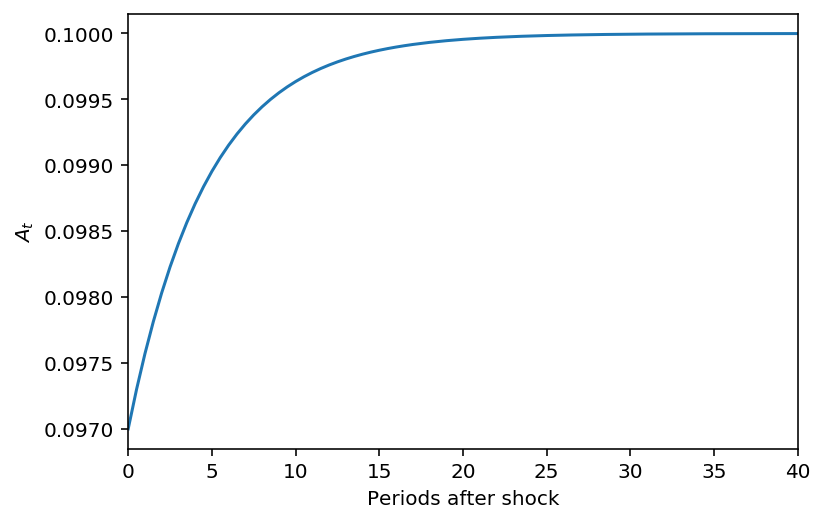

In [2]:
ga = 2
rho = 0.05
d = 0.05
al = 1/3
Aprod = 0.1
z1 = 1
z2 = 2*z1
z = np.array([z1,z2]).reshape((1,2))
la1 = 1/3
la2 = 1/3
la = [la1,la2]
z_ave = (z1*la2 + z2*la1)/(la1 + la2)

T = 200
N = 400
dt = T/N
time = np.arange(0,N)*dt
max_price_it = 300
convergence_criterion = 10**(-5)
relax = 0.1

#construct TFP sequence
corr = 0.8
nu = 1-corr
Aprod_t = np.zeros(N)
Aprod_t[0]=.97*Aprod
for n in range(0,N-1):
    Aprod_t[n+1] = dt*nu*(Aprod-Aprod_t[n]) + Aprod_t[n]

plt.plot(time,Aprod_t)
plt.ylabel(r'$A_t$')
plt.xlabel(r'Periods after shock')
plt.xlim((0,40))
plt.show()

In [3]:
I= 1000
amin = -0.8
amax = 20
a = np.linspace(amin,amax,I)
da = (amax-amin)/(I-1)

aa = np.array([a,a]).T
zz = np.ones((I,1))*z


maxit= 100
crit = 10**(-6)
Delta = 1000

dVf = np.zeros((I,2))
dVb = np.zeros((I,2))
c = np.zeros((I,2))
v0 = np.zeros((I,2))


Aswitch = sparse.vstack( (  sparse.hstack( (-sparse.eye(I)*la[0],sparse.eye(I)*la[0]) ) , 
                            sparse.hstack( (sparse.eye(I)*la[1],-sparse.eye(I)*la[1]) ) 
                         ) )

Ir = 40
crit_S = 10**(-5)
V_n = np.zeros( (I,2,maxit) )
V_r = np.zeros( (I,2,Ir) )
g_r = np.zeros( (I,2,Ir) )
adot = np.zeros( (I,2,Ir) )

rmax = 0.049
r = 0.04
w = 0.05

v0[:,0] = (w*z[0,0] + r*a)**(1-ga)/(1-ga)/rho
v0[:,1] = (w*z[0,1] + r*a)**(1-ga)/(1-ga)/rho

r0 = 0.03
rmin = 0.01
rmax = 0.99*rho

In [4]:
################
# STEADY STATE #
################
r_r = [None]*Ir
rmin_r = [None]*Ir
rmax_r = [None]*Ir
KD = [None]*Ir
KS = [None]*Ir
S = [None]*Ir


start = tic()
for ir in range(0,Ir):

    r_r[ir] = r
    rmin_r[ir] = rmin
    rmax_r[ir] = rmax

    KD[ir] = (al*Aprod/(r + d))**(1/(1-al))*z_ave
    w = (1-al)*Aprod*KD[ir]**al*z_ave**(-al)

    if ir > 0:
        v0 = V_r[:,:,ir-1]


    v = v0
    dist = []

    
    for n in range(0,maxit):
        V = v
        V_n[:,:,n] = V
        # forward difference
        dVf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
        dVf[I-1,:] = (w*z + r*amax)**(-ga) #will never be used, but impose state constraint a<=amax just in case
        # backward difference
        dVb[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
        dVb[0,:] = (w*z + r*amin)**(-ga) #state constraint boundary condition

        #consumption and savings with forward difference
        cf = dVf**(-1/ga)
        ssf = w*zz + r*aa - cf
        #consumption and savings with backward difference
        cb = dVb**(-1/ga)
        ssb = w*zz + r*aa - cb
        #consumption and derivative of value function at steady state
        c0 = w*zz + r*aa
        dV0 = c0**(-ga)

        # dV_upwind makes a choice of forward or backward differences based on
        # the sign of the drift    
        If = ssf > 0 #positive drift --> forward difference
        Ib = ssb < 0 #negative drift --> backward difference
        I0 = (1-If-Ib) #at steady state
        #make sure backward difference is used at amax
        #Ib(I,:) = 1 If(I,:) = 0
        #STATE CONSTRAINT at amin: USE BOUNDARY CONDITION UNLESS muf > 0:
        #already taken care of automatically

        dV_Upwind = dVf*If + dVb*Ib + dV0*I0 #important to include third term
        c = dV_Upwind**(-1/ga)
        u = c**(1-ga)/(1-ga)

        #CONSTRUCT MATRIX
        X = -np.minimum(ssb,0)/da
        Y = -np.maximum(ssf,0)/da + np.minimum(ssb,0)/da
        Z = np.maximum(ssf,0)/da

        A1 = sparse.spdiags(Y[:,0],0,I,I)+sparse.spdiags(X[1:I,0],-1,I,I)+sparse.spdiags(np.concatenate( (np.zeros(1),Z[0:I-1,0]) ),1,I,I)
        A2 = sparse.spdiags(Y[:,1],0,I,I)+sparse.spdiags(X[1:I,1],-1,I,I)+sparse.spdiags(np.concatenate( (np.zeros(1),Z[0:I-1,1]) ),1,I,I)
        A = sparse.vstack( (  sparse.hstack( (A1,sparse.csr_matrix( (I,I)) ) ), \
                              sparse.hstack( (sparse.csr_matrix( (I,I)),A2) ) )) + Aswitch

        B = (1/Delta + rho)*sparse.eye(2*I) - A
        

        u_stacked = np.hstack( (u[:,0], u[:,1]) )
        V_stacked = np.hstack( (V[:,0], V[:,1])  )
        

        b = u_stacked + V_stacked/Delta
        V_stacked = sparse.linalg.spsolve(B, b) #SOLVE SYSTEM OF EQUATIONS
        
        V = V_stacked.reshape((I,2), order = 'F')

        Vchange = V - v
        v = V

        dist.append( np.max(abs(Vchange)) )
        if dist[n] < crit:
            end = tic()
            print('Value Function Converged, Iteration = %1.0f in %1.2f seconds' % (n, end-start))
            break
    

    ##########################
    # FOKKER-PLANCK EQUATION #
    ##########################
    AT = A.T
    b = np.zeros((2*I,1))

    #need to fix one value, otherwise matrix is singular
    i_fix = 0
    b[i_fix] = .1
    row = np.hstack( (1, np.zeros(I*2-1)) )
    AT[i_fix,:] = row

    #Solve linear system
    gg = sparse.linalg.spsolve(AT,b)
    g_sum = np.dot(gg.T, np.ones( (2*I,1) )*da)
    gg = gg/g_sum

    g = gg.reshape((I,2), order = 'F' )

    check1 = np.dot(g[:,0].T, np.ones((I,1))*da)
    check2 = np.dot(g[:,1].T, np.ones((I,1))*da)

    g_r[:,:,ir] = g
    adot[:,:,ir] = w*zz + r*aa - c
    V_r[:,:,ir] = V

    KS[ir] = np.dot(g[:,0].T,a*da) + np.dot(g[:,1].T,a*da)
    S[ir] = KS[ir] - KD[ir]

    #UPDATE INTEREST RATE
    if S[ir] > crit_S:
        print('Excess Supply')
        rmax = r
        r = 0.5*(r+rmin)
    elif S[ir] < -crit_S:
        print('Excess Demand')
        rmin = r
        r = 0.5*(r+rmax)
    elif abs(S[ir]) < crit_S:
        print('Equilibrium Found, Interest rate = %1.3f' % r)
        break
        

Value Function Converged, Iteration = 7 in 0.07 seconds
Excess Demand
Value Function Converged, Iteration = 7 in 0.18 seconds
Excess Demand


/Users/joaobduarte/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Value Function Converged, Iteration = 6 in 0.28 seconds
Excess Demand
Value Function Converged, Iteration = 7 in 0.41 seconds
Excess Supply
Value Function Converged, Iteration = 6 in 0.70 seconds
Excess Supply
Value Function Converged, Iteration = 5 in 0.89 seconds
Excess Demand
Value Function Converged, Iteration = 5 in 1.00 seconds
Excess Demand
Value Function Converged, Iteration = 4 in 1.12 seconds
Excess Supply
Value Function Converged, Iteration = 4 in 1.27 seconds
Excess Supply
Value Function Converged, Iteration = 4 in 1.55 seconds
Excess Demand
Value Function Converged, Iteration = 4 in 1.68 seconds
Excess Demand
Value Function Converged, Iteration = 4 in 1.79 seconds
Excess Demand
Value Function Converged, Iteration = 3 in 2.01 seconds
Excess Supply
Value Function Converged, Iteration = 3 in 2.17 seconds
Excess Supply
Value Function Converged, Iteration = 3 in 2.27 seconds
Excess Supply
Value Function Converged, Iteration = 3 in 2.38 seconds
Excess Supply
Value Function Conve

In [5]:
#save some objects
v_st = v
gg_st = gg
K_st = KS[ir]
w_st = w
r_st = r
C_st = np.dot(gg.T,np.reshape(c,(I*2,1), order = 'F')*da)
Aprod_st = Aprod

#######################
# TRANSITION DYNAMICS #
#######################
gg0 = gg_st

del Delta, r, w, Aprod, gg

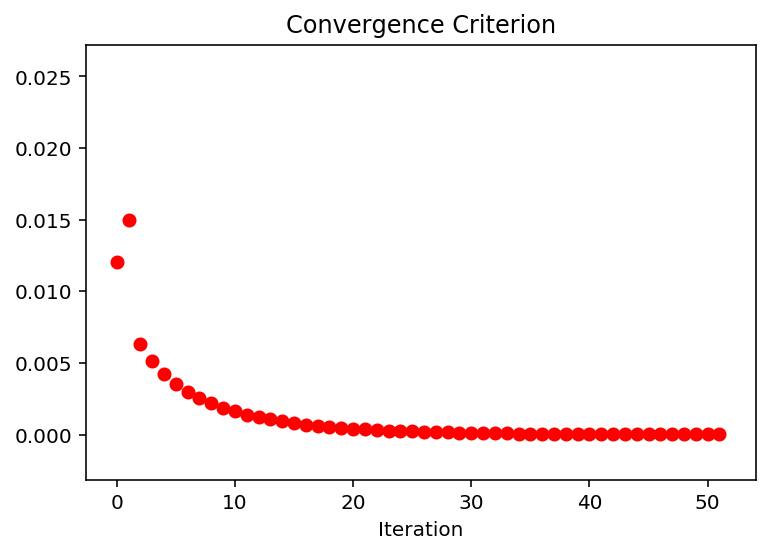

9.03808183499999e-06
Equilibrium Found


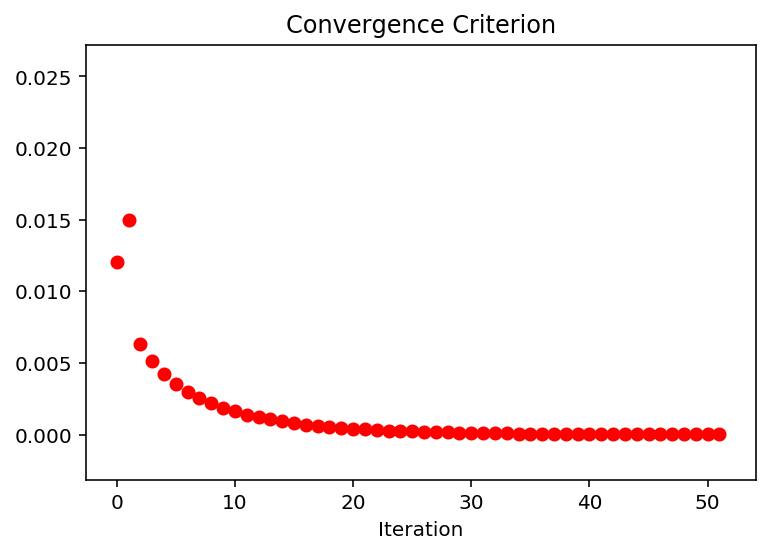

In [32]:
#preallocation
gg = [None]*(N+1)
A_t = [None]*N
dist_it = [None]*N
K_t = np.zeros((N,1))
C_t = np.zeros((N,1))
K_out = np.zeros((N,1))
r_t = np.zeros((N,1))
w_t = np.zeros((N,1))
c_t = np.zeros( (I,2,N) )

#initial guess
K_t = K_st*np.ones((N,1))

from IPython import display
%matplotlib inline
import time
import pylab as pl

for it in range(0, max_price_it): #
    print('PRICE ITERATION = %1.0f' % it)
    
    w_t = (1-al)*Aprod_t*K_t[:,0]**al*z_ave**(-al)
    r_t = al*Aprod_t*K_t[:,0]**(al-1)*z_ave**(1-al) - d

    V = v_st
    
    
    # HJB backward!
    for n in range(N-1,-1,-1):
        # forward difference
        dVf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
        dVf[I-1,:] = (w_t[n]*z + r_t[n]*amax)**(-ga) #will never be used, but impose state constraint a<=amax just in case
        # backward difference
        dVb[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
        dVb[0,:] = (w_t[n]*z + r_t[n]*amin)**(-ga) #state constraint boundary condition

        #consumption and savings with forward difference
        cf = dVf**(-1/ga)
        ssf = w_t[n]*zz + r_t[n]*aa - cf
        #consumption and savings with backward difference
        cb = dVb**(-1/ga)
        ssb = w_t[n]*zz + r_t[n]*aa - cb
        #consumption and derivative of value function at steady state
        c0 = w_t[n]*zz + r_t[n]*aa
        dV0 = c0**(-ga)

        # dV_upwind makes a choice of forward or backward differences based on
        # the sign of the drift    
        If = ssf > 0 #positive drift --> forward difference
        Ib = ssb < 0 #negative drift --> backward difference
        I0 = (1-If-Ib) #at steady state
        #make sure backward difference is used at amax
        #Ib(I,:) = 1 If(I,:) = 0
        #STATE CONSTRAINT at amin: USE BOUNDARY CONDITION UNLESS muf > 0:
        #already taken care of automatically

        dV_Upwind = dVf*If + dVb*Ib + dV0*I0 #important to include third term
        c = dV_Upwind**(-1/ga)
        u = c**(1-ga)/(1-ga)
        c_t[:,:,n] = c

        #CONSTRUCT MATRIX
        X = -np.minimum(ssb,0)/da
        Y = -np.maximum(ssf,0)/da + np.minimum(ssb,0)/da
        Z = np.maximum(ssf,0)/da
        
        
        A1 = sparse.spdiags(Y[:,0],0,I,I)+sparse.spdiags(X[1:I,0],-1,I,I)+sparse.spdiags(np.concatenate( (np.zeros(1),Z[0:I-1,0]) ),1,I,I)
        A2 = sparse.spdiags(Y[:,1],0,I,I)+sparse.spdiags(X[1:I,1],-1,I,I)+sparse.spdiags(np.concatenate( (np.zeros(1),Z[0:I-1,1]) ),1,I,I)
        A = sparse.vstack( (  sparse.hstack( (A1,sparse.csr_matrix( (I,I)) ) ), \
                              sparse.hstack( (sparse.csr_matrix( (I,I)),A2) ) )) + Aswitch
        
        A_t[n] = A #save for future reference

        B = (1/dt + rho)*sparse.eye(2*I) - A
        
        u_stacked = np.hstack( (u[:,0], u[:,1]) )
        V_stacked = np.hstack( (V[:,0], V[:,1])  )
        

        b = u_stacked + V_stacked/dt
        V_stacked = sparse.linalg.spsolve(B, b) #SOLVE SYSTEM OF EQUATIONS
        
        V = V_stacked.reshape((I,2), order = 'F')
    
    
    # KF forward!
    gg[0] = gg0
    for n in range(0,N):
        AT = A_t[n].T
        #Implicit method in Updating Distribution.
        gg[n+1] = sparse.linalg.spsolve((sparse.eye(2*I) - np.dot(AT,dt)),gg[n]) 
        #gg{n+1}=gg{n}+AT*gg{n}*dt #This is the explicit method.
        #check(n) = gg(:,n)'*ones(2*I,1)*da
        K_out[n] = np.dot(gg[n][0:I].T,a*da) + np.dot(gg[n][I:2*I].T, a*da)
        C_t[n] = np.dot(gg[n].T , np.reshape(c_t[:,:,n],(I*2,1), order = 'F')*da)

    
    dist_it[it] =  np.max(abs(K_out - K_t)) 
    
    # Nice plot to visually keep track of distance. Turn off if you want speed
    plt.scatter(it, dist_it[it], color = 'red')
    plt.title('Convergence Criterion')
    plt.xlabel('Iteration')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.01)
    
    print(dist_it[it])
    
    K_t = relax*K_out +(1-relax)*K_t

    if dist_it[it] < convergence_criterion:
        print('Equilibrium Found')
        plt.ioff()

        break

In [155]:
#######################
# INEQUALITY MEASURES #
#######################

Wealth_neg_t = np.zeros(N)
CapInc_Gini_t = np.zeros(N)
Wealth_Gini_t = np.zeros(N)
Income_Gini_t = np.zeros(N)
top_inc_t = np.zeros(N)
top_wealth_t = np.zeros(N)
neg_frac_t = np.zeros(N)

for n in range(0,N):
    Wealth_neg_t[n] = np.dot(gg[n][0:I].T, np.minimum(a,0)*da) + np.dot(gg[n][I:2*I].T, np.minimum(a,0)*da)
    g_a_cont = gg[n][0:I]+gg[n][I:2*I]
    
    #Discrete Gini to check
    g_a = g_a_cont*da
    S_a = np.cumsum(g_a*a)/sum(g_a*a)
    trapez_a = (1/2)*(S_a[0]*g_a[0] + np.sum((S_a[1:I] + S_a[0:I-1])*g_a[1:I]))
    Wealth_Gini_t[n] = 1 - 2*trapez_a

    #Gini of capital income
    yk = r_t[n]*a
    g_yk = g_a

    S_yk = np.cumsum(g_yk*yk)/np.sum(g_yk*yk)
    trapez_yk = (1/2)*(S_yk[0]*g_yk[0] + np.sum((S_yk[1:I] + S_yk[0:I-1])*g_yk[1:I]))
    CapInc_Gini_t[n] = 1 - 2*trapez_yk

    #Gini of total income
    y = w_t[n]*zz + r_t[n]*aa
    Ny = 2*I
    yy = np.reshape(y,(Ny,1), order = 'F')
    
    index = np.argsort(yy, axis=0)
    yy.sort(axis = 0)
    
    g_y = gg[n][index]*da
    
    S_y = np.cumsum(g_y*yy)/np.sum(g_y*yy)
    trapez_y = (1/2)*(S_y[0]*g_y[0] + np.sum(( S_y[1:Ny] + S_y[0:Ny-1])*g_y[1:Ny].reshape(Ny-1)))
    Income_Gini_t[n] = 1 - 2*trapez_y
    

    G_y = np.cumsum(g_y)
    G_a = np.cumsum(g_a)

    #Top 10# Income Share
    p1 = 0.1
    obj, index = np.min(abs((1-G_y) - p1)), np.argmin(abs((1-G_y) - p1))
    top_inc_t[n] = 1-S_y[index]

    #Top 10# Wealth Share
    p1 = 0.1
    obj, index = np.min(abs((1-G_a) - p1)), np.argmin(abs((1-G_a) - p1))
    top_wealth_t[n] = 1-S_a[index]
    
    neg_frac_t[n] = np.max(G_a[a <= 0])

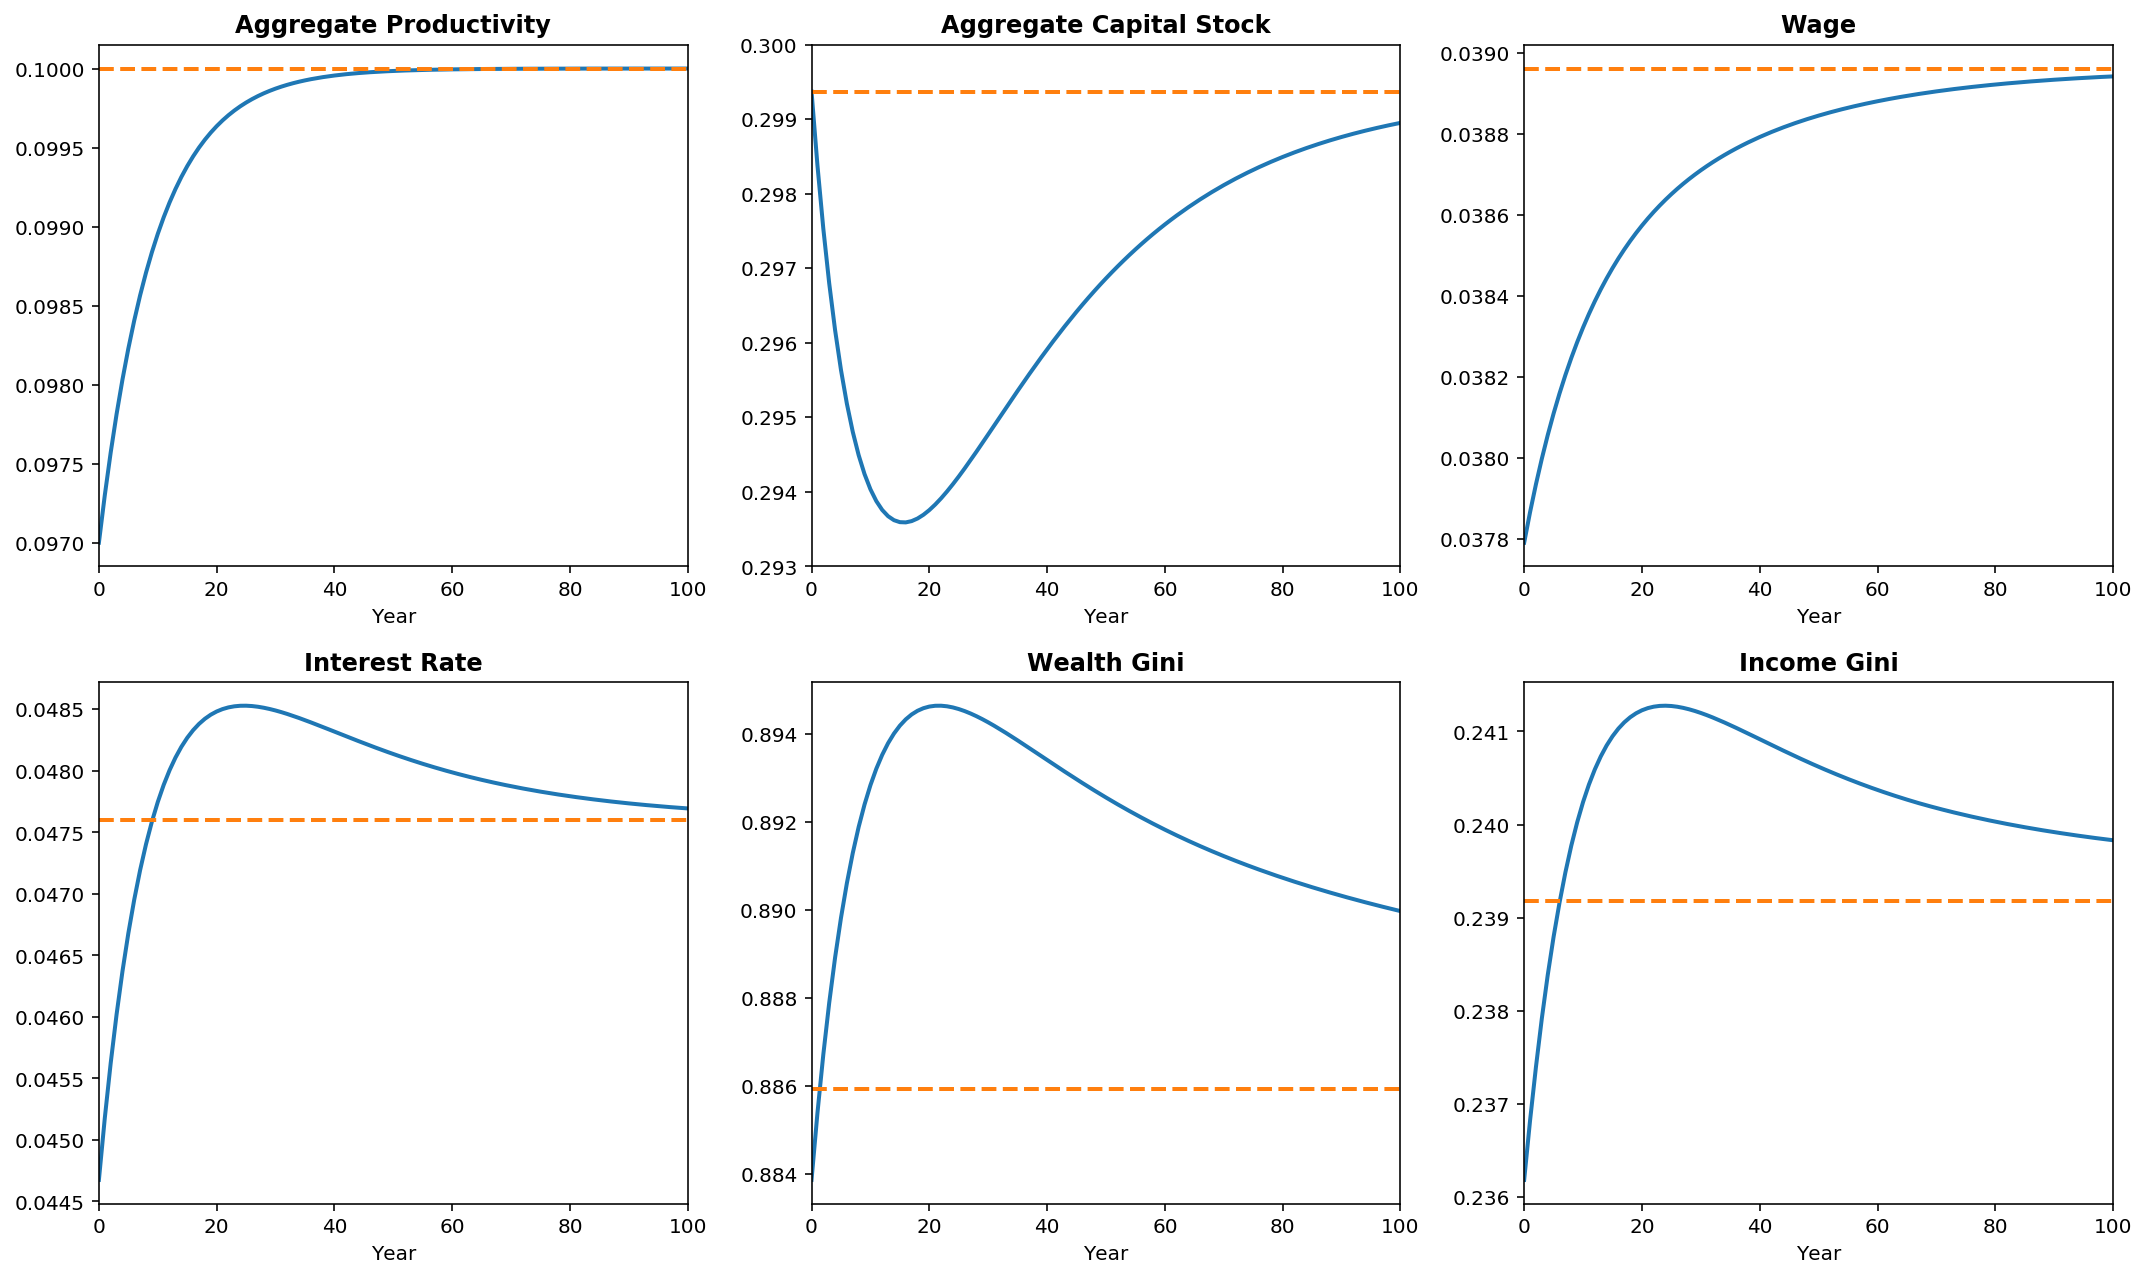

In [157]:
fig, ax = plt.subplots(2,3, figsize = (15, 9))

ax[0,0].plot(np.arange(0,N), Aprod_t, lw = 2)
ax[0,0].plot(np.arange(0,N), Aprod_st*np.ones(N),'--', lw = 2)
ax[0,0].set_xlim((0, 100))
ax[0,0].set_xlabel('Year')
ax[0,0].set_title('Aggregate Productivity', fontweight="bold")

ax[0,1].plot(np.arange(0,N), K_t, lw = 2)
ax[0,1].plot(np.arange(0,N), K_st*np.ones(N),'--', lw = 2)
ax[0,1].set_xlim((0, 100))
ax[0,1].set_ylim((0.293, 0.3))
ax[0,1].set_xlabel('Year')
ax[0,1].set_title('Aggregate Capital Stock', fontweight="bold")

ax[0,2].plot(np.arange(0,N), w_t, lw = 2)
ax[0,2].plot(np.arange(0,N), w_st*np.ones(N),'--', lw = 2)
ax[0,2].set_xlim((0, 100))
ax[0,2].set_xlabel('Year')
ax[0,2].set_title('Wage', fontweight="bold")

ax[1,0].plot(np.arange(0,N), r_t, lw = 2)
ax[1,0].plot(np.arange(0,N), r_st*np.ones(N),'--', lw = 2)
ax[1,0].set_xlim((0, 100))
ax[1,0].set_xlabel('Year')
ax[1,0].set_title('Interest Rate', fontweight="bold")

ax[1,1].plot(np.arange(0,N), Wealth_Gini_t, lw = 2)
ax[1,1].plot(np.arange(0,N), Wealth_Gini_t[N-1]*np.ones(N),'--', lw = 2)
ax[1,1].set_xlim((0, 100))
ax[1,1].set_xlabel('Year')
ax[1,1].set_title('Wealth Gini', fontweight="bold")

ax[1,2].plot(np.arange(0,N), Income_Gini_t, lw = 2)
ax[1,2].plot(np.arange(0,N), Income_Gini_t[N-1]*np.ones(N),'--', lw = 2)
ax[1,2].set_xlim((0, 100))
ax[1,2].set_xlabel('Year')
ax[1,2].set_title('Income Gini', fontweight="bold")


plt.tight_layout()
plt.savefig('aiyagari_irfs_A_shock.pdf')
plt.show()